<a href="https://colab.research.google.com/github/Muradrassam2024/Murad/blob/main/Final_codes_Anomaly_Detection_Using_Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import DetCurveDisplay, RocCurveDisplay

## Load the data

In [21]:
from google.colab import files
uploaded=files.upload()

Saving sub441ready.csv to sub441ready.csv


In [22]:
data=pd.read_csv('sub441ready.csv', header=None)
print(data.shape)
data.head()

(14277, 7)


,0,1,2,3,4,5,6
0,95.8,151.5,94.1,115.2,95.5,96.1,0
1,91.9,148.4,91.4,112.1,91.9,95.1,0
2,92.4,149.7,94.1,114.4,93.0,96.2,0
3,107.8,149.7,95.8,115.7,107.0,96.8,0
4,101.6,153.2,96.0,117.2,99.0,96.8,0


## Split the data for training and testing

In [23]:
# last column is the target
# 0 = anomaly, 1 = normal
TARGET = 6

features = data.drop(TARGET, axis=1)
target = data[TARGET]

x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, stratify=target)


In [24]:
# use case is novelty detection so use only the normal data
# for training
train_index = y_train[y_train == 1].index
train_data = x_train.loc[train_index]

## Scale the data using MinMaxScaler

In [25]:
min_max_scaler = MinMaxScaler(feature_range=(0, 1))
x_train_scaled = min_max_scaler.fit_transform(train_data.copy())
x_test_scaled = min_max_scaler.transform(x_test.copy())

## Build an AutoEncoder model

In [26]:
# create a model by subclassing Model class in tensorflow
class AutoEncoder(Model):
  """
  Parameters
  ----------
  output_units: int
    Number of output units

  code_size: int
    Number of units in bottle neck
  """

  def __init__(self, output_units, code_size=8):
    super().__init__()
    self.encoder = Sequential([
      Dense(512, activation='relu'),
      Dropout(0.1),
      Dense(256, activation='relu'),
      Dropout(0.1),
      Dense(128, activation='relu'),
      Dropout(0.1),
      Dense(code_size, activation='relu')
    ])
    self.decoder = Sequential([
      Dense(128, activation='relu'),
      Dropout(0.1),
      Dense(256, activation='relu'),
      Dropout(0.1),
      Dense(512, activation='relu'),
      Dropout(0.1),
      Dense(output_units, activation='sigmoid')
    ])

  def call(self, inputs):
    encoded = self.encoder(inputs)
    decoded = self.decoder(encoded)
    return decoded

Epoch 1/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.0093 - mse: 0.0208 - val_loss: 0.0016 - val_mse: 0.0134
Epoch 2/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 3.7450e-04 - mse: 8.8597e-04 - val_loss: 0.0011 - val_mse: 0.0122
Epoch 3/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 2.2164e-04 - mse: 5.1791e-04 - val_loss: 0.0011 - val_mse: 0.0121
Epoch 4/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 1.8957e-04 - mse: 4.3004e-04 - val_loss: 9.9273e-04 - val_mse: 0.0119
Epoch 5/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 1.2892e-04 - mse: 3.0004e-04 - val_loss: 0.0010 - val_mse: 0.0119
Epoch 6/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 1.0866e-04 - mse: 2.4464e-04 - val_loss: 8.8006e-04 - val_mse: 0.0116
Epoch 7/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 9.4605e-05 - mse: 2.1286e-04 - val_loss: 9.0140e-04 - val_mse: 0.0116
Epoch 8/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 8.5478e-05 - mse: 1.8745e-04 - val_loss: 9.3276e-

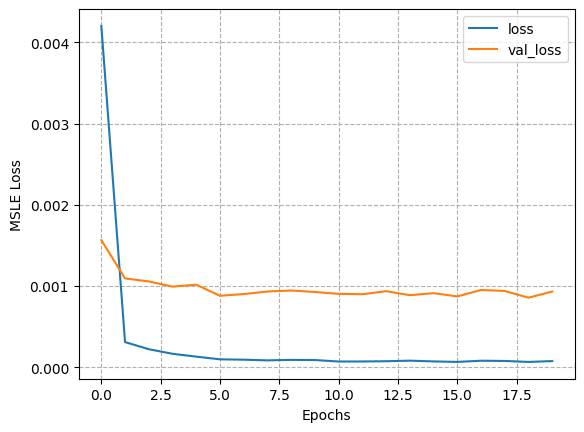

285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Threshold method one: 0.00034181048480633127
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Precision: 0.9444444444444444
Recall: 0.9710017574692443
F1 Score: 0.9575389948006933


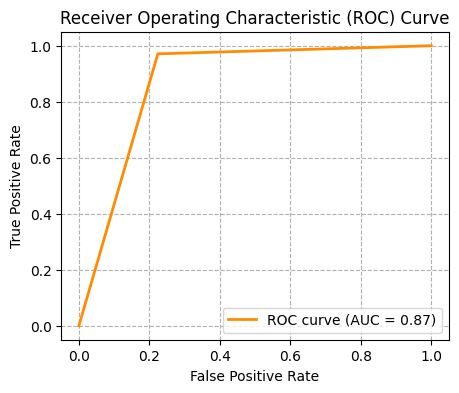

In [33]:
# Appling the Autoencoder Model
model = AutoEncoder(output_units=x_train_scaled.shape[1])
# configurations of model
model.compile(loss='msle', metrics=['mse'], optimizer='adam')

history = model.fit(
    x_train_scaled,
    x_train_scaled,
    epochs=20,
    batch_size=32,
    validation_data=(x_test_scaled, x_test_scaled)
)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('MSLE Loss')
plt.grid(linestyle="--")

plt.legend(['loss', 'val_loss'])
plt.show()

#===================================================
#Finding the threshold

def find_threshold(model, x_train_scaled):
  reconstructions = model.predict(x_train_scaled)
  # provides losses of individual instances
  reconstruction_errors = tf.keras.losses.msle(reconstructions, x_train_scaled)

  # threshold for anomaly scores
  threshold = np.mean(reconstruction_errors.numpy()) \
      + np.std(reconstruction_errors.numpy())
  return threshold

def find_threshold_method_two(model, x_train_scaled):
  # another method to find threshold
  reconstructions = model.predict(x_train_scaled)
  # provides losses of individual instances
  reconstruction_errors = tf.keras.losses.msle(reconstructions, x_train_scaled)

  threshold_2 = np.percentile(reconstruction_errors, 95)
  return threshold_2

#==============================================================
# Making predictions based on the Unsupervised Autoencoder model
def get_predictions(model, x_test_scaled, threshold):
  predictions = model.predict(x_test_scaled)
  # provides losses of individual instances
  errors = tf.keras.losses.msle(predictions, x_test_scaled)
  # 0 = anomaly, 1 = normal
  anomaly_mask = pd.Series(errors) > threshold
  preds = anomaly_mask.map(lambda x: 0.0 if x == True else 1.0)
  return preds

threshold = find_threshold(model, x_train_scaled)
print(f"Threshold method one: {threshold}")

#threshold_2 = find_threshold_method_two(model, x_train_scaled)
#print(f"Threshold method two: {threshold_2}")

preds = get_predictions(model, x_test_scaled, threshold)
accuracy_score(preds, y_test)

# Assuming 'true_labels' is a binary array indicating true anomalies (1) and normal instances (0)
# Adjust this array based on your labeled data
true_labels=target[x_test.index]

# Use the 'anomalies' array from the previous code as predicted labels
# Adjust this array based on the anomalies predicted by your autoencoder model
predicted_labels = preds
#===============================================
# Calculate precision, recall, and F1 score
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Assuming 'predictions' are the output of your autoencoder and 'true_labels' are the actual labels
fpr, tpr, _ = roc_curve(true_labels, preds)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(5, 4))
plt.grid(linestyle="--")
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
#plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


## Plot history